**Objective** : Classify the emergency and non emergency vehicles

1. Total Images : 1646 in Train, 706 in Test
2. Traning a restnet 18 model for 2 classes
3. Use Reduce LR on Plateau
4. Loss : Crossentropy
5. Epochs: 30
6. Leader board Score : 97.60


In [ ]:
import sys
sys.path.append("/content/drive/My Drive/codebase/")
# !pip install pytorch-lr-finder

**Section 1:**

1. Imports
2. Set the PATH
3. "time" to save model and submissions for every run



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary

In [ ]:
print(os.getcwd())
#config
data_folder = "/content/drive/My Drive/train/"
csv_path = "/content/drive/My Drive/train/train.csv"
model_path = "/content/drive/My Drive/train/"
save_path = "/content/drive/My Drive/submissions/"

/content


In [ ]:
import time
time_ind = int(time.time())
save_name = "submission_"+str(time_ind)


**Section 2: Import Userdefined Function**

*In this section we have imported the function for below task Below is a list of user defined functions*

1. Create Custom Dataset
2. Importing pretrained models
3. Create the custom model
4. model traning module
5. Plot module for accuracy and loss curves
6. Create confusion Matrix
7. Modle validation module


In [1]:
from data_loader import vehicleDatasets
from visulaize import show_images
from pretrained_model_load import get_resnet18
from train import train_model
from test_model import validate_model, create_confusion_matrix
from plotting_lib import plot_loss_curves, plot_accuracy_curves

**Section 3:
This is the main code**
1. Create the transfromations for train data
2. SPlit the data into train and validation
3. Have a look at some random samples from a batch
4. View the summary of the model
5. Train the Model
6. Plot loss and accuracy for all epochs
7. Show misclassified images


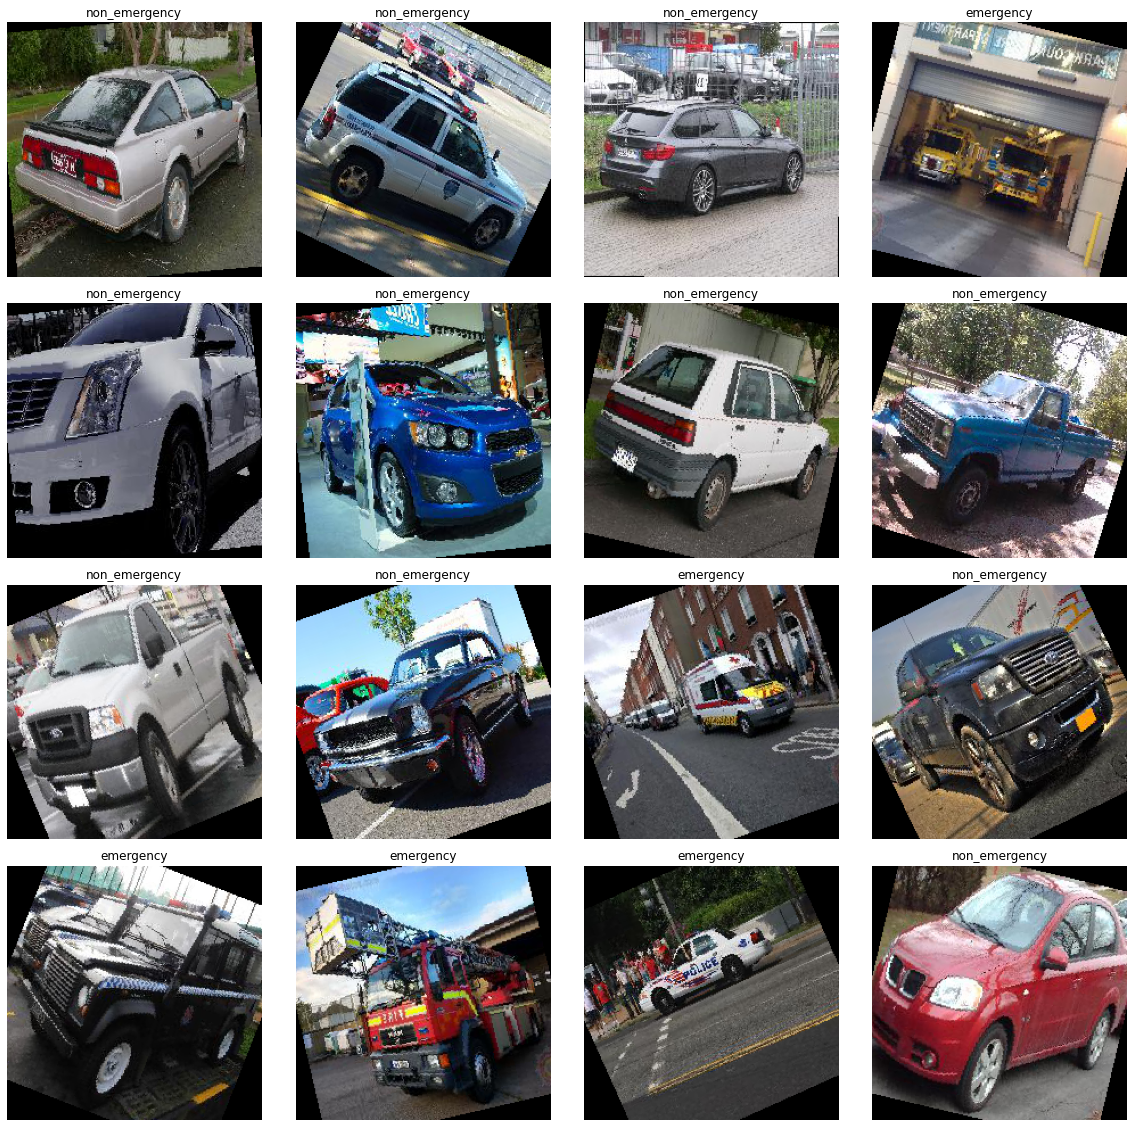

In [ ]:
import albumentations as A
mytransform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  # transforms.ColorJitter(0.3,0.4,0.2,0.3),
                                  transforms.RandomRotation(30),
                                  # transforms.RandomCrop(180),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# image_datasets = {x: vehicleDatasets(csv_path, data_folder,transforms=mytransform)
                  # for x in ['train', 'val']}
dataset = vehicleDatasets(csv_path, data_folder,transforms=mytransform)

train_set, val_set = torch.utils.data.random_split(dataset, [1400, 246])
image_datasets = {'train':train_set, 'val':val_set}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}

mydataloader = dataloaders['train']
# classes = image_datasets['train'].get_classes()
classes = dataset.get_classes()


data = iter(mydataloader)
samples = data.next()
# show images
plt.figure(figsize=(16,16))
for i in range(0,16):
    sample = {'image':samples['image'][i],'target':samples['target'][i].item()}
    ax = plt.subplot(4, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')
    show_images(**sample,classes= classes, transpose=True, normalise=True)
    if i == 15:
        plt.show()
        break

**LOAD MODEL**

In [ ]:
# Model
torch.cuda.manual_seed_all(10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mymodel = get_resnet18()
mymodel = mymodel.to(device)
summary(mymodel,input_size=(3,224,224))
print(device)

512
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1,

**TRAIN MODEL**

In [ ]:
# !pip install pytorch-lr-finder
# !pip install torch-lr-finder -v --global-option="apex"

# from torch_lr_finder import LRFinder
# mycriterion = nn.CrossEntropyLoss()
# myoptimizer = optim.SGD(mymodel.parameters(), lr=0.001, momentum=0.9)
# lr_finder = LRFinder(mymodel, myoptimizer, mycriterion, device=device)
# lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
epochs = 20
mycriterion = nn.CrossEntropyLoss()
# mycriterion = nn.BCELoss()
# mycriterion = torch.nn.BCEWithLogitsLoss()

myoptimizer = optim.SGD(mymodel.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(myoptimizer, step_size=10, gamma=0.2)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(myoptimizer, verbose=True)

best_model,train_losses,train_accuracy, val_losses, val_accuracy, misclassdata,misclasstargets= train_model(model=mymodel,
            criterion=mycriterion,
            num_epochs=epochs,
            optimizer=myoptimizer,
            scheduler = lr_scheduler,
            dataloaders=dataloaders,
            device = device,
            dataset_size=dataset_sizes)


# torch.load('file.pt')

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.6982 Acc : 0.5057


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.6727 Acc : 0.5569
Epoch 1/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.6378 Acc : 0.6236


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.6285 Acc : 0.6016
Epoch 2/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.6022 Acc : 0.7136


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.5765 Acc : 0.8130
Epoch 3/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.5665 Acc : 0.7893


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.5343 Acc : 0.8537
Epoch 4/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.5288 Acc : 0.8421


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4946 Acc : 0.8862
Epoch 5/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.5016 Acc : 0.8636


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4742 Acc : 0.8821
Epoch 6/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4815 Acc : 0.8714


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4561 Acc : 0.9065
Epoch 7/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4631 Acc : 0.8843


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4455 Acc : 0.9187
Epoch 8/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4473 Acc : 0.8907


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4360 Acc : 0.8780
Epoch 9/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4346 Acc : 0.9071


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4235 Acc : 0.9146
Epoch 10/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4315 Acc : 0.9086


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4192 Acc : 0.8984
Epoch 11/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4236 Acc : 0.9121


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4124 Acc : 0.9228
Epoch 12/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4149 Acc : 0.9236


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4116 Acc : 0.9106
Epoch 13/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4092 Acc : 0.9236


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4071 Acc : 0.9106
Epoch 14/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4050 Acc : 0.9221


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.4005 Acc : 0.9268
Epoch 15/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.4028 Acc : 0.9243


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.3950 Acc : 0.9228
Epoch 16/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.3931 Acc : 0.9364


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.3970 Acc : 0.9228
Epoch 17/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.3921 Acc : 0.9314


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.3950 Acc : 0.9350
Epoch 18/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.3955 Acc : 0.9286


  0%|          | 0/22 [00:00<?, ?it/s]

val Loss: 0.3890 Acc : 0.9350
Epoch 19/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.3857 Acc : 0.9379


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

val Loss: 0.3881 Acc : 0.9390


**SAVE MODEL and SHOW STATS**

In [ ]:
torch.save(misclassdata, save_path+save_name+'missclass_imgs.pt')
torch.save(misclasstargets, save_path+save_name+'missclass_labels.pt')
torch.save(best_model, save_path+save_name+'model.pt')

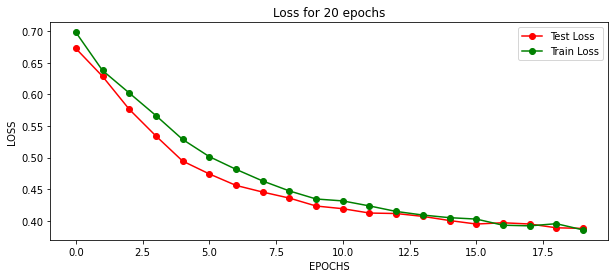

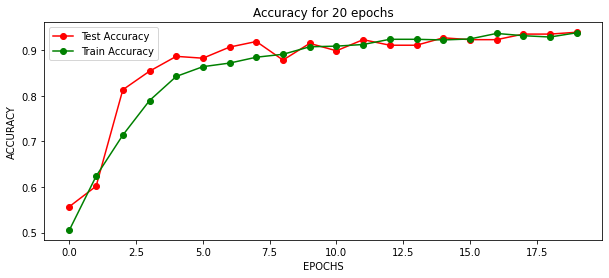

In [ ]:
showMeasurePlots.plot_loss_curves(train_losses,val_losses,epochs,saveplot=True)
showMeasurePlots.plot_accuracy_curves(train_accuracy,val_accuracy,epochs,saveplot=True)

**Test the mosel on Validation set**

Below is the plot for some sample prediction. The image 4 was not predicted properly. Let us look the accuray and other missclassified images below.

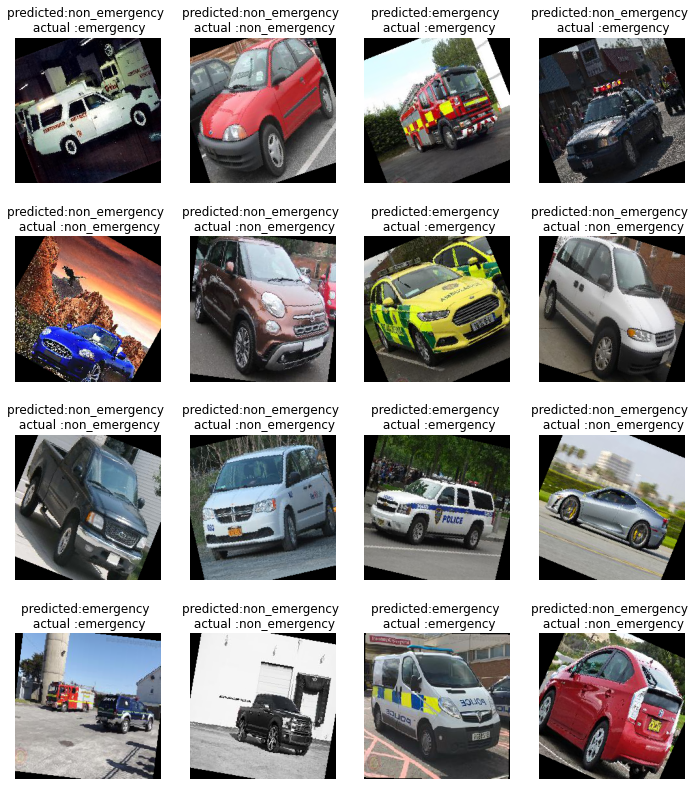

In [ ]:
misclass_data,misclass_targets,misclass_preds, cmatrix, acc = validate_model(best_model,dataloaders,device,16,classes)

In [ ]:
print("Total Misclassification:",misclass_data.size()[0])
print("Confusion Matrix:",cmatrix)
print("Accuracy:",acc)

Total Misclassification: 19
Confusion Matrix: tensor([[133,   4],
        [ 15,  94]])
Accuracy: 0.9227642276422764


**Show Missclassified images:**

We have 19 missclassification in the validation data

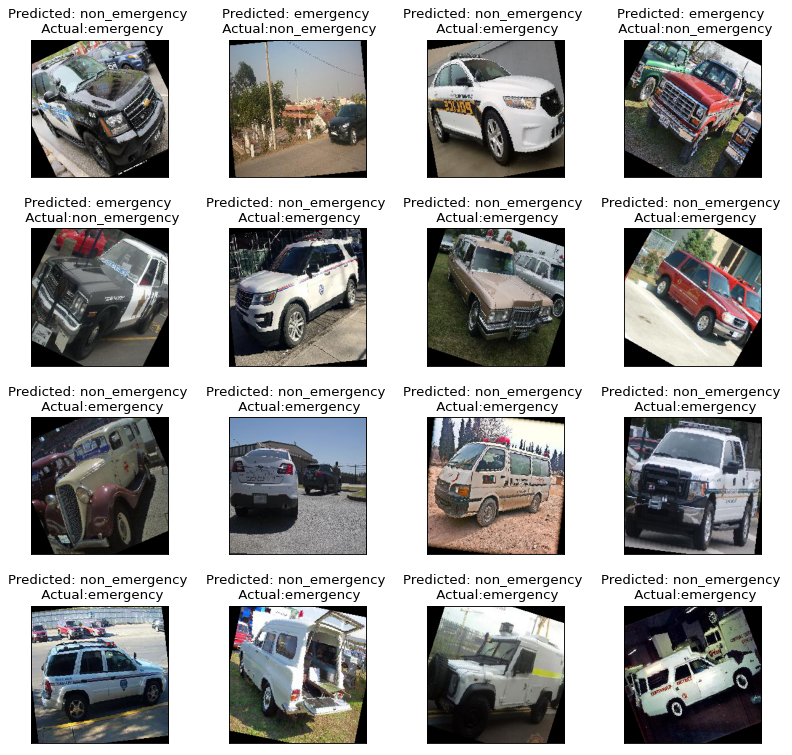

In [ ]:
fig = plt.figure(num=None, figsize=(10, 10),dpi=80, facecolor='w', edgecolor='k')
misclass_targets = misclass_targets.cpu().numpy()
misclass_pred = misclass_preds.cpu().numpy()
for num in range(0,misclass_data.size()[0]):
  if num < 16:
    plt.subplot(4,4,num+1)
    plt.tight_layout()
    mis_class_img = misclass_data[num]
    mis_class_img_cpu = mis_class_img.cpu()

    plt_image = mis_class_img_cpu.numpy().transpose(1,2,0)
    plt_image = plt_image / 2 + 0.5
    # plt_image = np.uint8(255*plt_image)
    plt.imshow(plt_image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted: {} \n Actual:{}".format(classes[misclass_pred[num]], classes[misclass_targets[num]]))
plt.show()

**Submission**

1. Set the path for the test data
2. dataloader and datatransformation for the Test data
3. Read the saved model and predict
4. Write the submission to the disk

In [ ]:
test_csv_path = "/content/drive/My Drive/test.csv"
testtransform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testdataset = vehicleDatasets(test_csv_path, data_folder,transforms=testtransform)
testloader = torch.utils.data.DataLoader(testdataset, 
                                         batch_size=128,
                                         shuffle=False,
                                         num_workers=4)
model = torch.load(save_path+save_name+'model.pt')
# model.eval()

In [ ]:
import torch
import matplotlib.pyplot as plt

def test_model(model, testloader,device,classes):
    was_training = model.training
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch, sample in enumerate(testloader):
            inputs = sample['image']
            inputs = inputs.to(device)
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            preds = preds.cpu().numpy().tolist()
            predictions = predictions + preds
        model.train(mode=was_training)
    return predictions


In [ ]:
predictions = test_model(model,testloader,device,classes)
print("Total:",len(predictions),"Sum:",sum(predictions))

Total: 706 Sum: 297


In [ ]:
import pandas as pd
test_csv_path = "/content/drive/My Drive/test.csv"
submission_data = pd.read_csv(test_csv_path)
submission_data['emergency_or_not'] = predictions
submission_data.head()
submission_data.to_csv(save_path+save_name+".csv",index=False)

image_names  emergency_or_not
0    1960.jpg                 0
1     668.jpg                 1
2    2082.jpg                 0
3     808.jpg                 1
4    1907.jpg                 0